<a href="https://colab.research.google.com/github/SSockYep/DSA/blob/master/MalwareDetectFromCuckoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import random
import os
from torchtext.data import Field, LabelField, TabularDataset, Dataset, BucketIterator



In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 설계

In [ ]:

class ClassifierWithAttention(nn.Module):
    def __init__(self, batch_size, vocab_size, embed_size, hidden_size, output_size):
        super(ClassifierWithAttention, self).__init__()

        '''
        batch_size: size of the batch
        vocab_size: size of vocabulary containing api name
        embed_size: Embedding dimension
        hidden_size: size of the hidden state of the LSTM
        output_size: 2 = (benign, malware)

        embedding: layer for embedding
        LSTM: LSTM layer
        out: fully connected layer
        act: sigmoid activation function
        '''
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(
            self.embed_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.act = nn.Sigmoid()

    def attention_net(self, lstm_output, final_state):
        '''
        lstm_output: (batch_size, num_seq, hidden_size)
        hidden: (batch_size, hidden_size, 1)

        compute attention weight by batch matrix multiplication of lstm_output and hidden
        attn_weight: (batch_size, num_seq)
        attn_applied: (batch_size, hidden_size)
        
        '''
        hidden = final_state.view(-1, self.hidden_size, 1)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        attn_weights = F.softmax(attn_weights, 1)
        attn_applied = torch.bmm(
            lstm_output.transpose(1, 2), attn_weights.unsqueeze(2)
        ).squeeze(2)
        return attn_applied, attn_weights

    def forward(self, input):
        '''
        parameter
        input: tensor shape of number of sequence of API ID

        returns
        output: output of one-hot encoded vector.
        output.shape == self.output_size (normally 2 for benign and malware)
        attn_weight: attention weights
        '''
        embedded = self.embedding(input) # embedding input
        embedded = embedded.permute(1, 0, 2) # (batch_size, num_seq, hidden_size) -> (num_seq, batch_size, hidden_size)

        # initialize hidden state and cell
        h_0 = torch.zeros(1, len(input), self.hidden_size).cuda()
        c_0 = torch.zeros(1, len(input), self.hidden_size).cuda()

        lstm_output, (hidden, cell) = self.lstm(embedded, (h_0, c_0))
        lstm_output = lstm_output.permute(1, 0, 2) # (num_seq, batch_size, hidden_size) -> (batch_size, num_seq, hidden_size)

        attn_applied, attn_weights = self.attention_net(lstm_output, hidden) # apply attention

        output = self.out(attn_applied)
        output = output.squeeze()
        output = self.act(output)

        return output, attn_weights

    def initHidden(self):
        return torch.zroes(1, 1, self.hidden_size, device=device)


# trainer 함수

In [ ]:

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    num_corrects = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        api, api_length = batch.api

        output, attn = model(api)
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if len(batch) == 1:
          output = output.unsqueeze(0)
        loss = criterion(output, target)
        num_corrects = (torch.max(output, 1)[1].view(
            target.size()).data == target.data).sum()

        acc = torch.true_divide(num_corrects, len(batch))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


# evaluate 함수

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            api, api_length = batch.api

            predictions, attn = model(api)
            predictions = predictions.squeeze()

            target = batch.label
            target = torch.autograd.Variable(target).long()

            if len(batch) == 1:
              predictions = predictions.unsqueeze(0)
            loss = criterion(predictions, target)
            num_corrects = (torch.max(predictions, 1)[1].view(
                target.size()).data == target.data).sum()
            acc = torch.true_divide(num_corrects, len(batch))

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 데이터 로드, train

In [ ]:
import sys
import csv

maxInt = sys.maxsize
while True:
  try:
    csv.field_size_limit(maxInt)
    break
  except OverflowError:
    maxInt //= 2

API = Field(
    sequential=True,
    lower=False,
    include_lengths=True,
    batch_first=True,
)
LABEL = LabelField()

fields = [('api', API), ('label', LABEL)]

data = TabularDataset(
    path="/content/gdrive/My Drive/data/calls.csv",
    format="csv",
    fields=fields,
    skip_header=True
)
train_data, valid_data = data.split(split_ratio=0.7)

API.build_vocab(train_data, max_size=1000)
LABEL.build_vocab(train_data)

BATCH_SIZE = 1

train_loader, valid_loader = BucketIterator.splits(
    (train_data, valid_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.api),
    device = device,
)

# parameters
num_id = len(API.vocab)
embedding_size = 100
num_hidden_nodes = 16
num_output_nodes = 2

model = ClassifierWithAttention(
    BATCH_SIZE, num_id, embedding_size, num_hidden_nodes, num_output_nodes)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

for epoch in range(5):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

  print("epoch {}".format(epoch+1))
  print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
  print(f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%")


epoch 1
	Train Loss: 0.673 | Train Acc: 60.11%
	Valid Loss: 0.644 | Valid Acc: 69.74%
epoch 2
	Train Loss: 0.601 | Train Acc: 76.12%
	Valid Loss: 0.584 | Valid Acc: 77.63%
epoch 3
	Train Loss: 0.531 | Train Acc: 80.34%
	Valid Loss: 0.551 | Valid Acc: 76.32%
epoch 4
	Train Loss: 0.490 | Train Acc: 84.27%
	Valid Loss: 0.539 | Valid Acc: 75.66%
epoch 5
	Train Loss: 0.463 | Train Acc: 85.39%
	Valid Loss: 0.531 | Valid Acc: 75.66%


# 모델 저장

In [ ]:
torch.save(model, "/content/gdrive/My Drive/data/model.pt")

# 예측 함수
model과 api_sequence를 입력하여 예측값, attention wieght matrix, 토크나이즈 된 시퀀스 출력

In [ ]:
def predict(model, api_sequence):
  tokenized = API.preprocess(api_sequence)
  indexed = [API.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(1).T
  out, atten_weights = model(tensor)
  out = F.softmax(out, 0)
  prediction = LABEL.vocab.itos[torch.argmax(out)]
  return prediction, atten_weights, tokenized
  
  

# Cuckoo Sandbox report parse

In [ ]:
# parsing cuckoo report json
import json

def parse_report_json(filename):
  with open(filename, 'r') as f:
    data = json.load(f)
    calls = []
    if data.get("behavior"):
      if data["behavior"].get("processes"):
        for d in data["behavior"]["processes"]:
          for call in d["calls"]:
            calls.append(call["api"])
    return ' '.join(calls)

# 임의의 benign file의 예측 결과에서 top 10 attention weight visualization


<BarContainer object of 10 artists>

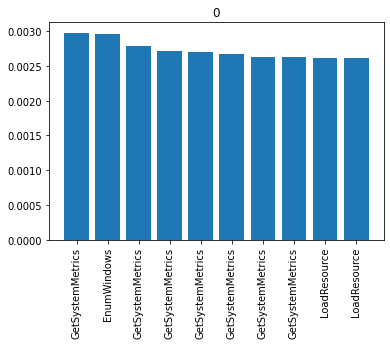

In [ ]:
import matplotlib.pyplot as plt
import os
import random

model = torch.load("/content/gdrive/My Drive/data/model.pt")
model.eval()

# predict: predicted vector
# attn: attention weight vector

filelist = os.listdir("/content/gdrive/Shared drives/Instruction API Sequence/KISA-CISC2017-Malware-2nd/dynamic/0/")

while True:
  filename = random.choice(filelist)
  if filename[-4:] == 'json':
    filename = "/content/gdrive/Shared drives/Instruction API Sequence/KISA-CISC2017-Malware-2nd/dynamic/0/" + filename
    break
benign_api = parse_report_json(filename)

prediction, attn, tokenized = predict(model, benign_api)
attn = attn.cpu().detach().numpy().squeeze()

# attention visualization

# attention on api sequence
plt.title(prediction)
# plt.subplot(1,3,1)
# plt.bar(np.arange(len(attn)), attn)

# plt.subplot(1,3,2)
# plt.xticks(rotation=90)
# plt.bar(tokenized, attn, tick_label=tokenized)

sort_arg = attn.argsort()
sort_arg = sort_arg[::-1]
sorted_attn = attn[sort_arg]
sorted_api_name = np.array(tokenized)[sort_arg]

# plt.subplot(1,3,3)
plt.xticks(rotation=90)
# top 10 attentions on api calls
plt.bar(np.arange(len(sorted_attn[:10])), sorted_attn[:10], tick_label=sorted_api_name[:10])



# 임의의 malware file의 예측 결과에서 top 10 attention weight visualization

<BarContainer object of 10 artists>

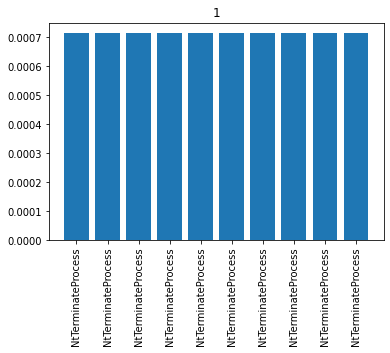

In [ ]:
filelist = os.listdir("/content/gdrive/Shared drives/Instruction API Sequence/KISA-CISC2017-Malware-2nd/dynamic/1/")

while True:
  filename = random.choice(filelist)
  if filename[-4:] == 'json':
    filename = "/content/gdrive/Shared drives/Instruction API Sequence/KISA-CISC2017-Malware-2nd/dynamic/1/" + filename
    break
malware_api = parse_report_json(filename)
prediction, attn, tokenized = predict(model, malware_api)
attn = attn.cpu().detach().numpy().squeeze()

# attention visualization
# attention on api sequence
# plt.subplot(3,1,1)
plt.title(prediction)
# plt.bar(np.arange(len(attn)), attn)

# plt.subplot(3,1,2)
# plt.xticks(rotation=90)
# plt.bar(tokenized, attn, tick_label=tokenized)

sort_arg = attn.argsort()
sort_arg = sort_arg[::-1]
sorted_attn = attn[sort_arg]
sorted_api_name = np.array(tokenized)[sort_arg]

# plt.subplot(3,1,3)
plt.xticks(rotation=90)
# top 10 attentions on api calls
plt.bar(np.arange(len(sorted_attn[:10])), sorted_attn[:10], tick_label=sorted_api_name[:10])


In [ ]:
import os

PATH = "/content/gdrive/Shared drives/Instruction API Sequence/KISA-CISC2017-Malware-2nd/dynamic/"
with open("/content/gdrive/My Drive/data/final_result.csv", 'w') as f:
  f.write("prediction,real_data,attetion_top10\n")
  for i in range(2):
    file_dir = PATH + str(i) + '/'
    count = 0
    for filename in os.listdir(file_dir):
      print('\r', end='')
      print('%.2f'%(count/700*100)+'%', end='')
      if filename[-4:] == "json":
        api_seq = parse_report_json(file_dir+filename)
        if len(api_seq) > 0:
          prediction, attn, tokenized = predict(model, api_seq)
          attn = attn.cpu().detach().numpy().squeeze()
          sort_arg = attn.argsort()
          sorted_api_name = np.array(tokenized)[sort_arg[::-1]]
          f.write(prediction+','+str(i)+','+' '.join(sorted_api_name[:10])+'\n')
          count += 1
        if count > 700:
          break